Copyright ©2021-2022. Stephen Rigden.
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program.  If not, see <http://www.gnu.org/licenses/>.

# Plot Blood Pressure

Change History
9/28/2021 Started
10/15/2021 Reviewed and tidied up for production use.
10/23/2021 Modified to use pandas resampling toolset instead of iso_date

In [21]:
import pandas
from pathlib import Path
from matplotlib import pyplot
import seaborn
seaborn.set_style('darkgrid')  # one of {darkgrid, whitegrid, dark, white, ticks}

In [22]:
project_path = Path.cwd().parent
heart_preprocessed = project_path / 'data' / 'processed' / 'heart_preprocessed.pickle'
blood_pressure_df_pickle = project_path / 'data' / 'processed' / 'blood_pressure_df.pickle'
blood_pressure_pdf = project_path / 'reports' / 'blood_pressure.pdf'
blood_pressure_jpg = project_path / 'reports' / 'blood_pressure.jpg'

### Get the raw data and analyse its structure

In [23]:
ds = pandas.read_pickle(heart_preprocessed)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176911 entries, 5 to 176915
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   value   176911 non-null  float64       
 1   type    176911 non-null  object        
 2   date    176911 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.4+ MB


In [24]:
ds.date.min()

Timestamp('2020-03-30 20:11:49')

In [25]:
ds.date.max()

Timestamp('2021-12-01 18:19:16')

In [26]:
ds['type'].value_counts()

HKQuantityTypeIdentifierHeartRate                 176143
HKQuantityTypeIdentifierBloodPressureSystolic        384
HKQuantityTypeIdentifierBloodPressureDiastolic       384
Name: type, dtype: int64

In [27]:
ds.head()

,value,type,date
5,67.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:11:49
6,67.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:16:17
7,61.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:09
8,64.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:13
9,63.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:18


In [28]:
ds.tail()

,value,type,date
176911,76.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-11-29 23:18:00
176912,72.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-11-29 23:56:00
176913,72.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-11-30 03:41:00
176914,76.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-11-30 21:29:00
176915,79.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-11-30 22:52:00


### Create a dataset of blood pressure records

In [29]:
bp_diastolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureDiastolic'
dds = ds.loc[bp_diastolic, ['date', 'value']]
dds = dds.rename(columns={'value': 'diastolic'})
dds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 176532 to 176915
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       384 non-null    datetime64[ns]
 1   diastolic  384 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.0 KB


In [30]:
dds.head()

,date,diastolic
176532,2021-08-06 20:53:00,79.0
176533,2021-08-06 20:58:00,85.0
176534,2021-08-06 23:13:00,77.0
176535,2021-08-07 01:14:00,73.0
176536,2021-08-07 22:21:00,71.0


In [31]:
bp_systolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureSystolic'
sds = ds.loc[bp_systolic, ['date', 'value']]
sds = sds.rename(columns={'value': 'systolic'})
sds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 176148 to 176531
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      384 non-null    datetime64[ns]
 1   systolic  384 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.0 KB


In [32]:
sds.head()

,date,systolic
176148,2021-08-06 20:53:00,153.0
176149,2021-08-06 20:58:00,136.0
176150,2021-08-06 23:13:00,135.0
176151,2021-08-07 01:14:00,121.0
176152,2021-08-07 22:21:00,132.0


In [33]:
bpds = sds.merge(dds, left_on=['date'], right_on=['date'])
bpds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       384 non-null    datetime64[ns]
 1   systolic   384 non-null    float64       
 2   diastolic  384 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 12.0 KB


In [34]:
bpds.head()

,date,systolic,diastolic
0,2021-08-06 20:53:00,153.0,79.0
1,2021-08-06 20:58:00,136.0,85.0
2,2021-08-06 23:13:00,135.0,77.0
3,2021-08-07 01:14:00,121.0,73.0
4,2021-08-07 22:21:00,132.0,71.0


In [35]:
bpds['pulse_pressure'] = bpds['systolic'] - bpds['diastolic']
bpds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            384 non-null    datetime64[ns]
 1   systolic        384 non-null    float64       
 2   diastolic       384 non-null    float64       
 3   pulse_pressure  384 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 15.0 KB


In [36]:
bpds.head()

,date,systolic,diastolic,pulse_pressure
0,2021-08-06 20:53:00,153.0,79.0,74.0
1,2021-08-06 20:58:00,136.0,85.0,51.0
2,2021-08-06 23:13:00,135.0,77.0,58.0
3,2021-08-07 01:14:00,121.0,73.0,48.0
4,2021-08-07 22:21:00,132.0,71.0,61.0


In [37]:
ds.to_pickle(blood_pressure_df_pickle)

## Group by varying periods using [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.resample.html?highlight=resample#pandas.core.groupby.DataFrameGroupBy.resample)
#### Create a DatetimeIndex

In [38]:
bpds.head()

,date,systolic,diastolic,pulse_pressure
0,2021-08-06 20:53:00,153.0,79.0,74.0
1,2021-08-06 20:58:00,136.0,85.0,51.0
2,2021-08-06 23:13:00,135.0,77.0,58.0
3,2021-08-07 01:14:00,121.0,73.0,48.0
4,2021-08-07 22:21:00,132.0,71.0,61.0


In [39]:
bpdsi = bpds.set_index('date')
bpdsi.head()

,systolic,diastolic,pulse_pressure
date,,,
2021-08-06 20:53:00,153.0,79.0,74.0
2021-08-06 20:58:00,136.0,85.0,51.0
2021-08-06 23:13:00,135.0,77.0,58.0
2021-08-07 01:14:00,121.0,73.0,48.0
2021-08-07 22:21:00,132.0,71.0,61.0


In [40]:
bpdsi_day = bpdsi.resample('D').mean()
bpdsi_day.head()

,systolic,diastolic,pulse_pressure
date,,,
2021-08-06,141.333333,80.333333,61.00
2021-08-07,125.400000,73.000000,52.40
2021-08-08,128.875000,75.625000,53.25
2021-08-09,126.500000,78.000000,48.50
2021-08-10,122.000000,75.000000,47.00


<AxesSubplot:xlabel='date'>

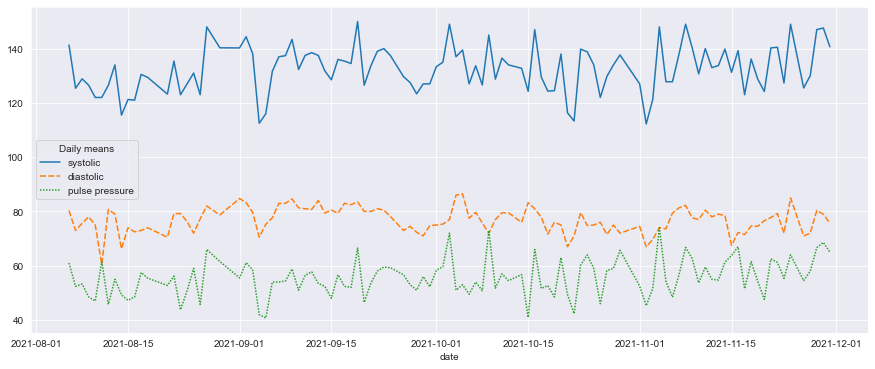

In [41]:
fig, axes_ = pyplot.subplots(figsize=(15, 6))
plot = seaborn.lineplot(data=bpdsi_day, palette='tab10', linewidth=1.5, ax=axes_)
plot.legend(labels=['systolic', 'diastolic', 'pulse pressure'], title='Daily means')
plot

In [42]:
fig.savefig(blood_pressure_jpg)
fig.savefig(blood_pressure_pdf)